In [112]:
import jupyterlab_dash
import dash
import pandas as pd
from nglui.statebuilder import *
from dashdataframe import configure_app
import numpy as np
import matplotlib.pyplot as plt

In [93]:
soma_subgraph_df = pd.read_csv('../soma_subgraph_synapses_spines_v185.csv')

In [94]:
# we need the position in voxel in a single column
# to make nglui work correctly
soma_subgraph_df.loc[:, 'ctr_pos']=soma_subgraph_df.apply(lambda x: [x.ctr_pos_x_vx, x.ctr_pos_y_vx, x.ctr_pos_z_vx], axis=1).copy()


In [95]:
# setup a nglui pipeline to visualize synapses
# get sources from the neuroglancer link
img_source = "precomputed://gs://neuroglancer/pinky100_v0/son_of_alignment_v15_rechunked"
seg_source = "precomputed://gs://microns_public_datasets/pinky100_v185/seg"

# use nglui (www.github.com/seung-lab/NeuroglancerAnnotationUI) to setup a dataframe > neuroglancer link pipeline
img_layer = ImageLayerConfig(name='layer23',
                             source=img_source,
                             )
# we want the segmentation layer with our target neuron always on
seg_layer = SegmentationLayerConfig(name = 'seg',
                                    source = seg_source)

# need to consolidate the synapse position into a single column

# setup a mapping rule for point annotations
# in this case this is setup to light up pre and post partner
syn_points = PointMapper(point_column='ctr_pos', linked_segmentation_column=['pre_root_id', 'post_root_id'])

# add these points linked to the segmentation layer name
syn_layer = AnnotationLayerConfig(name='synapses', mapping_rules=syn_points, linked_segmentation_layer='seg')
# setup a state builder with this layer pipeline
sb = StateBuilder([img_layer, seg_layer, syn_layer])

In [96]:
# simple function to take the selected
# rows based upon user selection
# filter the dataframe
# and use the nglui pipeline to generate
# a neuroglancer link
def visualize_synapses( selected_ids, df):
    dff=df.loc[selected_ids]
    return sb.render_state(dff, return_as='url')


In [97]:
viewer = jupyterlab_dash.AppViewer()

app = dash.Dash(__name__)
# only some of the columns make sense to scatter plot
# this configures the link that is generated at the bottom 
# to be dynamically calculated by the 'visualize_synapses'
# function
configure_app(app, soma_subgraph_df,
              link_func=visualize_synapses, link_name='ngl synapse link',
              plot_columns = ['cleft_vx', 'spine_vol_um3', 'ctr_pt_x_nm', 'ctr_pt_y_nm', 'ctr_pt_z_nm'])

viewer.show(app)

Now lets do some analysis that reproduces results from Dorkenwald et al. 2019

https://www.biorxiv.org/content/10.1101/2019.12.29.890319v1

but now in a dynamic plot

In [120]:
# the paper works in log volume units
soma_subgraph_df['log_spine_vol_um3']=np.log10(soma_subgraph_df.spine_vol_um3)
soma_subgraph_df['log_cleft_vx']=np.log(soma_subgraph_df.cleft_vx)

conn_grouped=soma_subgraph_df.groupby(['pre_root_id', 'post_root_id'])

# average size of synapses in connection (both log first and straight)
mean_size_df=conn_grouped[['cleft_vx','log_spine_vol_um3','log_cleft_vx', 'spine_vol_um3']].transform('mean')
# how many total synapses are involved with this synapse connection
count_df = conn_grouped['cleft_vx'].transform('count')
count_df.name='num_syn_in_conn'

In [121]:
mean_size_df.columns=['mean_cleft_vx', 'mean_log_spine_vol_um3', 'mean_log_cleft_vx','mean_spine_vol_um3']
mean_size_df

,mean_cleft_vx,mean_log_spine_vol_um3,mean_log_cleft_vx,mean_spine_vol_um3
0,798.000000,-0.876135,6.682109,0.133004
1,209.000000,-1.056534,5.342334,0.087794
2,589.666667,-0.897432,6.238515,0.140721
3,589.666667,-0.897432,6.238515,0.140721
4,589.666667,-0.897432,6.238515,0.140721
...,...,...,...,...
1956,74.000000,-1.600121,4.304065,0.025112
1957,211.000000,-1.524232,5.351858,0.029907
1958,134.000000,-1.220009,4.897840,0.060255
1959,95.000000,-1.831054,4.553877,0.014755


In [122]:
new_df = pd.concat([soma_subgraph_df, mean_size_df, count_df], axis=1)

Text(0.5, 1.0, 'see Figure 3d')

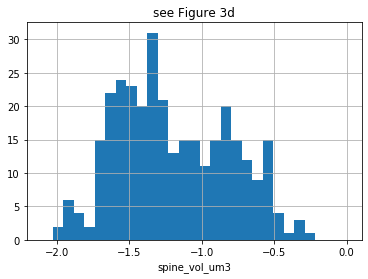

In [147]:
f, ax = plt.subplots()
new_df.query('num_syn_in_conn==2').log_spine_vol_um3.hist(bins=np.linspace(-2.1,0,30))
ax.set_xlabel('spine_vol_um3')
ax.set_title('see Figure 3d')

Text(0.5, 1.0, 'see Figure 3e')

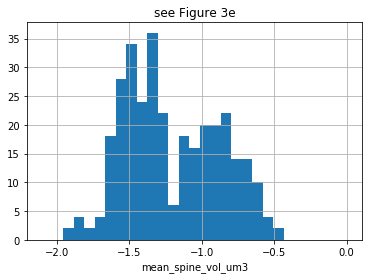

In [149]:
f, ax = plt.subplots()
new_df.query('num_syn_in_conn==2').mean_log_spine_vol_um3.hist(bins=np.linspace(-2.1,0,30))
ax.set_xlabel('mean_spine_vol_um3')
ax.set_title('see Figure 3e')

In [100]:
# # iterate over all connections in dataset
# for ind, grp in conn_grouped:
#     # for connections with nsyn>1
#     # 
#     if len(grp)>1:
#         print(ind)

In [150]:
# pick out the columns that are relevant
selected_columns = [ 'num_syn_in_conn', 'mean_spine_vol_um3', 'cleft_vx', 'spine_vol_um3',
       'ctr_pt_x_nm', 'ctr_pt_y_nm', 'ctr_pt_z_nm', 'log_spine_vol_um3', 'log_cleft_vx',
       'mean_cleft_vx', 'mean_log_spine_vol_um3', 'mean_log_cleft_vx']

In [152]:
viewer = jupyterlab_dash.AppViewer()

app = dash.Dash(__name__)
# now you can explore this dataset, and select synapses based upon
# their aggregate connection properties
# as well as their individual properties
# you can select synapses involved in dual or more than dual connections
# and then hit filter on the left to only show those points
# as you change the x,y axis on the scatter plot.
# the link will keep updating to include annotation points
# for the synapses you select.
configure_app(app, new_df,
              link_func=visualize_synapses, link_name='ngl synapse link',
              plot_columns = selected_columns)

viewer.show(app)